# EXTRACT MINST DATA

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq


import cirq
import sympy
import numpy as np
from numpy import linalg as LA
import copy
import itertools
import collections
import json


# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


2023-07-11 16:41:30.264633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-11 16:41:30.264652: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-11 16:41:34.035893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-11 16:41:34.035911: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-11 16:41:34.035927: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joan-Huawei): /proc/driver/nvidia/version does not exist
2023-07-11 16:41:34.036342: I tensorflow/core/platform/cpu_featur

In [2]:
# Load MNIST dataset from keras datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 

# The images are a grayscale from 0 (black) to 255 (white). We rescale the 
# images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

# np.newaxis adds another dimension, that indicates the number of channels. Because we are 
# on grayscale this will be one. (n_samples, 28, 28) -> (n_samples, 28, 28, 1)

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
def filter_36(x, y):
    """
    Filters our dataset and returns only the ones that represent either a 3 or a 6. We will 
    perform binary classification instead of multiple classification.
    """
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))


Number of filtered training examples: 12049
Number of filtered test examples: 1968


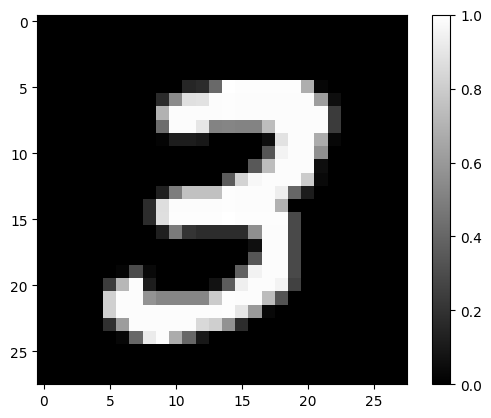

In [4]:
# shows one sample with the original size of 28 x 28. The grayscale is represented
# with a 

plt.imshow(x_train[0, :, :, 0], cmap="gray")
plt.colorbar()

2023-07-11 16:41:47.080996: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75571328 exceeds 10% of free system memory.


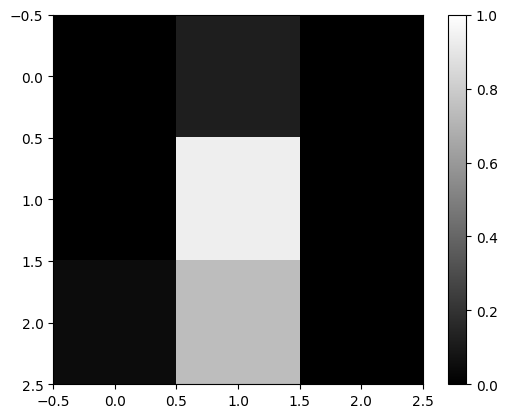

In [5]:
# Resize the image to a 3 by 3. This is done because we need N qubits per pixel. This makes
# the model to train very slowly (4 by 4 around 5 hours)

x_train_small = tf.image.resize(x_train, (3,3)).numpy()
x_test_small = tf.image.resize(x_test, (3,3)).numpy()

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1, cmap="gray")
plt.colorbar()


# QUANTUM MODELS

## QCNN - ANGLE ENCODING

### DATA ENCODING

In [6]:
def angle_encoding(qubits, data_row):
    """
    Perform angle encoding by applying a Ry gate. The values are scaled between -pi and 
    pi before being applied to the rotational gate in order that the encoded angles cover
    the entire range of possible values for a qubit rotation.
    """
    circuit = cirq.Circuit()
    values = data_row#*2*np.pi - np.pi  
    for i, qubit in enumerate(qubits):
        circuit += (cirq.ry(values[i]).on(qubit))
    return circuit

In [7]:
#We want output of 1 of -1
y_train = 2.0*y_train - 1.0
y_test = 2.0*y_test - 1.0


qubits = cirq.GridQubit.rect(1, 9) #grid of qubit -> for angle encoding we have N qubits 
# for N pixels.

# np.ravel flattens the 3 by 3 matrix into a 9 length array.

quantum_states_train = [np.ravel(x_train_small[i]) for i in range(len(x_train_small))]
quantum_states_test = [np.ravel(x_test_small[i]) for i in range(len(x_test_small))]

train_circuits_data = [angle_encoding(qubits, quantum_states_train[i]) for i in range(len(quantum_states_train))] 
test_circuits_data = [angle_encoding(qubits, quantum_states_test[i]) for i in range(len(quantum_states_test))] 


In [8]:
# convert the training quantum circuits into JSON format using cirq.to_json()

json_circuits = [cirq.to_json(train_circuits_data[i]) for i in range(len(train_circuits_data))]

# Open a file in write mode
with open('angle_encoding_train.json', 'w') as f:
    # Use json.dump() to write the list of JSON strings to the file
    json.dump(json_circuits, f)

# Same for the testing data circuits

json_circuits = [cirq.to_json(test_circuits_data[i]) for i in range(len(test_circuits_data))]

with open('angle_encoding_test.json', 'w') as f:
    json.dump(json_circuits, f)

np.savetxt("y_train.txt", y_train)
np.savetxt("y_test.txt", y_test)

### CIRCUITS FOR QCNN

In [9]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

def qfcc_3q(bits, symbols):
    """Make a 3 qubit quantum FCC"""
    
    circuit = cirq.Circuit()

    circuit += cirq.Y(bits[0])**(symbols[0])
    circuit += cirq.Y(bits[1])**(symbols[1])
    circuit += cirq.Y(bits[2])**(symbols[2])

    circuit += cirq.Z(bits[0])**(symbols[3])
    circuit += cirq.Z(bits[1])**(symbols[4])
    circuit += cirq.Z(bits[2])**(symbols[5])

    circuit += cirq.CNOT(bits[0], bits[1])
    circuit += cirq.CNOT(bits[0], bits[2])
    circuit += cirq.CNOT(bits[1], bits[2])

    circuit += cirq.Y(bits[0])**(symbols[6])
    circuit += cirq.Y(bits[1])**(symbols[7])
    circuit += cirq.Y(bits[2])**(symbols[8])

    circuit += cirq.Z(bits[0])**(symbols[9])
    circuit += cirq.Z(bits[1])**(symbols[10])
    circuit += cirq.Z(bits[2])**(symbols[11])

    circuit += cirq.CNOT(bits[0], bits[1])
    circuit += cirq.CNOT(bits[0], bits[2])
    circuit += cirq.CNOT(bits[1], bits[2])

    circuit += cirq.Y(bits[0])**(symbols[12])
    circuit += cirq.Y(bits[1])**(symbols[13])
    circuit += cirq.Y(bits[2])**(symbols[14])
    
    return circuit


In [10]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
        
    return circuit


def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

### VISUALIZATION OF POOLING AND CONVOLUTIONAL LAYERS

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

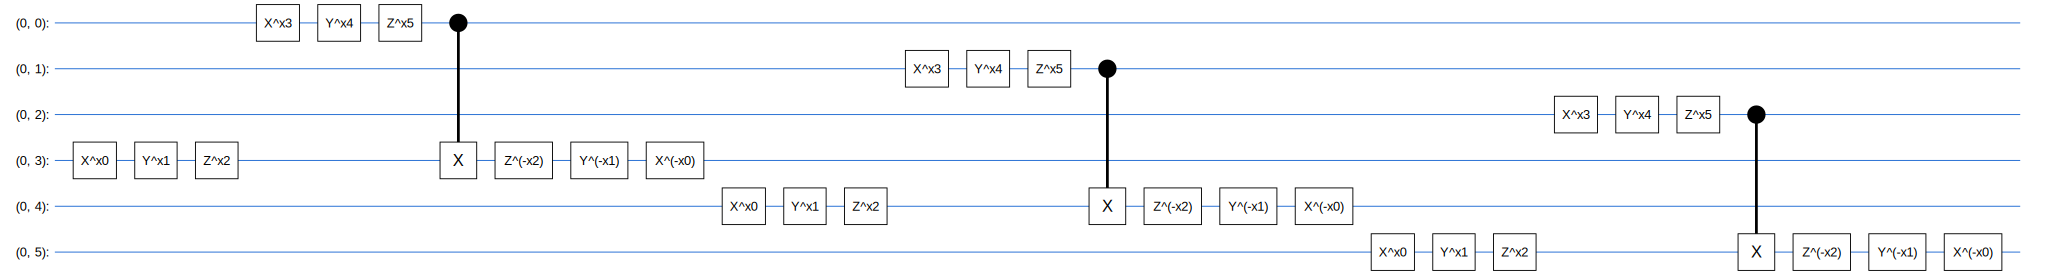

In [11]:
#plot the pooling circuit

test_bits = cirq.GridQubit.rect(1, 6)

SVGCircuit(
    quantum_pool_circuit(test_bits[:3], test_bits[3:], sympy.symbols('x0:6')))


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

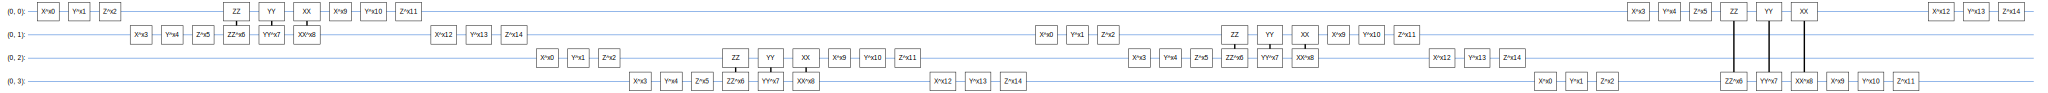

In [12]:
#plot the convulational circuit

SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 4), sympy.symbols('x0:15')))


### CREATE THE MODEL - QCNN WITH ANGLE ENCODING

<p style="font-size: larger;"> Decide how many convulational layers, pooling etc.... </p>

In [13]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:57')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
#    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])

    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:3], qubits[3:6], symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[3:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[3:6], qubits[6:], symbols[36:42])

    model_circuit += qfcc_3q(qubits[6:], symbols[42:57])
    
    return model_circuit




qubits = cirq.GridQubit.rect(1, 9) #grid of qubit 
readout_operators = cirq.Z(qubits[-1]) #grid of operator i want to average on (final expected value)

# Build a sequential model enacting the logic in 1.3 of this notebook.
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string) #still general input


#define the model 
quantum_model = tfq.layers.PQC(create_model_circuit(qubits),readout_operators)(inputs)

qcnn_model = tf.keras.Model(inputs=[inputs], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [14]:
import json

# Open the file in read mode
with open('angle_encoding_train.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
train_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((5000))]

# Open the file in read mode
with open('angle_encoding_test.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
test_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((500))]

y_train = np.loadtxt("y_train.txt")
y_test = np.loadtxt("y_test.txt")

y_train = y_train[:5000]
y_test = y_test[:500]


In [15]:
# convert data to tensors
train_circuits_data = tfq.convert_to_tensor(train_circuits_data)
test_circuits_data = tfq.convert_to_tensor(test_circuits_data)

In [16]:
# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

print(qcnn_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 pqc (PQC)                   (None, 1)                 57        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
qcnn_angle = qcnn_model.fit(x=train_circuits_data,
                         y=y_train,
                         batch_size=64,
                         epochs=50,
                         verbose=1,
                         validation_data=(test_circuits_data, y_test))


Epoch 1/50
79/79 [==============================] - 39s 492ms/step - loss: 0.9094 - custom_accuracy: 0.7455 - val_loss: 0.8393 - val_custom_accuracy: 0.8538
Epoch 2/50
79/79 [==============================] - 38s 486ms/step - loss: 0.8002 - custom_accuracy: 0.8402 - val_loss: 0.7554 - val_custom_accuracy: 0.8738
Epoch 3/50
79/79 [==============================] - 38s 485ms/step - loss: 0.7470 - custom_accuracy: 0.8372 - val_loss: 0.7167 - val_custom_accuracy: 0.8714
Epoch 4/50
79/79 [==============================] - 38s 483ms/step - loss: 0.7043 - custom_accuracy: 0.8483 - val_loss: 0.6711 - val_custom_accuracy: 0.8777
Epoch 5/50
79/79 [==============================] - 38s 486ms/step - loss: 0.6734 - custom_accuracy: 0.8477 - val_loss: 0.6467 - val_custom_accuracy: 0.8831
Epoch 6/50
79/79 [==============================] - 38s 482ms/step - loss: 0.6512 - custom_accuracy: 0.8562 - val_loss: 0.6264 - val_custom_accuracy: 0.8792
Epoch 7/50
79/79 [==============================] - 38s 48

### ENCODING - BASIS ENCODING

In [17]:
def basis_encoding(qubits, data_row):
    
    binary_datarow = np.where(data_row>0.5, 1, 0)
    circuit = cirq.Circuit()
    for i, qubit in enumerate(qubits):
        if binary_datarow[i] == 1:
            circuit += cirq.X.on(qubit)
        circuit 
    return circuit    


In [18]:
#We want output of 1 of -1
y_train = 2.0*y_train - 1.0
y_test = 2.0*y_test - 1.0

qubits = cirq.GridQubit.rect(1, 9) #grid of qubit -> for angle encoding we have N qubits 
# for N pixels.

quantum_states_train = [np.ravel(x_train_small[i]) for i in range(len(x_train_small))]
quantum_states_test = [np.ravel(x_test_small[i]) for i in range(len(x_test_small))]

train_circuits_data = [basis_encoding(qubits, quantum_states_train[i]) for i in range(len(quantum_states_train))] 
test_circuits_data = [basis_encoding(qubits, quantum_states_test[i]) for i in range(len(quantum_states_test))] 



In [19]:


# convert the training quantum circuits into JSON format using cirq.to_json()

json_circuits = [cirq.to_json(train_circuits_data[i]) for i in range(len(train_circuits_data))]

# Open a file in write mode
with open('basis_encoding_train.json', 'w') as f:
    # Use json.dump() to write the list of JSON strings to the file
    json.dump(json_circuits, f)

# Same for the testing data circuits

json_circuits = [cirq.to_json(test_circuits_data[i]) for i in range(len(test_circuits_data))]

with open('basis_encoding_test.json', 'w') as f:
    json.dump(json_circuits, f)

np.savetxt("y_train.txt", y_train)
np.savetxt("y_test.txt", y_test)

In [24]:
def create_model_circuit_basis(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:30')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
#    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])

    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += qfcc_3q(qubits[6:], symbols[15:30])
    

    
    
    return model_circuit

qubits = cirq.GridQubit.rect(1, 9) #grid of qubit 
readout_operators = cirq.Z(qubits[-1]) #grid of operator i want to average on (final expected value)

# Build a sequential model enacting the logic in 1.3 of this notebook.
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string) #still general input



#define the model 
quantum_model = tfq.layers.PQC(create_model_circuit_basis(qubits),readout_operators)(inputs)

qcnn_model = tf.keras.Model(inputs=[inputs], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [25]:
import json

# Open the file in read mode
with open('basis_encoding_train.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
train_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((5000))]

# Open the file in read mode
with open('basis_encoding_test.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
test_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((500))]

y_train = np.loadtxt("y_train.txt")
y_test = np.loadtxt("y_test.txt")

y_train = y_train[:5000]
y_test = y_test[:500]


In [26]:
# convert data to tensors
train_circuits_data = tfq.convert_to_tensor(train_circuits_data)
test_circuits_data = tfq.convert_to_tensor(test_circuits_data)

In [27]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

print(qcnn_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 pqc_2 (PQC)                 (None, 1)                 30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None


In [166]:
qcnn_basis = qcnn_model.fit(x=train_circuits_data,
                         y=y_train,
                         batch_size=64,
                         epochs=50,
                         verbose=1,
                         validation_data=(test_circuits_data, y_test))


Epoch 1/50
79/79 [==============================] - 16s 196ms/step - loss: 1.2632 - custom_accuracy: 0.5125 - val_loss: 0.8645 - val_custom_accuracy: 0.5380
Epoch 2/50
79/79 [==============================] - 15s 194ms/step - loss: 0.7501 - custom_accuracy: 0.8052 - val_loss: 0.6514 - val_custom_accuracy: 0.8343
Epoch 3/50
79/79 [==============================] - 15s 194ms/step - loss: 0.6353 - custom_accuracy: 0.8222 - val_loss: 0.5863 - val_custom_accuracy: 0.8343
Epoch 4/50
79/79 [==============================] - 16s 198ms/step - loss: 0.6000 - custom_accuracy: 0.8222 - val_loss: 0.5629 - val_custom_accuracy: 0.8343
Epoch 5/50
79/79 [==============================] - 16s 207ms/step - loss: 0.5858 - custom_accuracy: 0.8222 - val_loss: 0.5526 - val_custom_accuracy: 0.8343
Epoch 6/50
79/79 [==============================] - 16s 196ms/step - loss: 0.5788 - custom_accuracy: 0.8236 - val_loss: 0.5459 - val_custom_accuracy: 0.8343
Epoch 7/50
79/79 [==============================] - 16s 20

# CLASSICAL CNN

## CLASSICAL CNN - LENET MODEL

In [28]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)
x_train_small = tf.image.resize(x_train, (3,3)).numpy()
x_test_small = tf.image.resize(x_test, (3,3)).numpy()

2023-07-11 16:44:49.502520: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75571328 exceeds 10% of free system memory.


In [29]:
def cnn_lenet5():
    # A simple model based off LeNet5 from https://www.tensorflow.org/quantum/tutorials/mnist
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [2, 2], activation='relu', padding="same", input_shape=(3,3,1))) # changed input shape
    model.add(tf.keras.layers.Conv2D(64, [2, 2], activation='relu', padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = cnn_lenet5()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 3, 32)          160       
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          8256      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                        

In [30]:
lenet5 = model.fit(x_train_small,
          y_train,
          batch_size=128,
          epochs=50,
          verbose=1, # see the results with different output and animation dure the training
          validation_data=(x_test_small, y_test))

lenet5_results = model.evaluate(x_test_small, y_test)


Epoch 1/50
95/95 [==============================] - 1s 4ms/step - loss: 0.4453 - accuracy: 0.7874 - val_loss: 0.2778 - val_accuracy: 0.8877
Epoch 2/50
95/95 [==============================] - 0s 3ms/step - loss: 0.3078 - accuracy: 0.8754 - val_loss: 0.2638 - val_accuracy: 0.8994
Epoch 3/50
95/95 [==============================] - 0s 3ms/step - loss: 0.2976 - accuracy: 0.8802 - val_loss: 0.2608 - val_accuracy: 0.9024
Epoch 4/50
95/95 [==============================] - 0s 3ms/step - loss: 0.2915 - accuracy: 0.8837 - val_loss: 0.2549 - val_accuracy: 0.9019
Epoch 5/50
95/95 [==============================] - 0s 3ms/step - loss: 0.2863 - accuracy: 0.8859 - val_loss: 0.2536 - val_accuracy: 0.8943
Epoch 6/50
95/95 [==============================] - 0s 3ms/step - loss: 0.2807 - accuracy: 0.8881 - val_loss: 0.2480 - val_accuracy: 0.9004
Epoch 7/50
95/95 [==============================] - 0s 3ms/step - loss: 0.2761 - accuracy: 0.8908 - val_loss: 0.2486 - val_accuracy: 0.9096
Epoch 8/50
95/95 [==

## FAIR CLASSICAL MODEL - FNN 

<p style="font-size:larger;"> For the QCNN model we have used 57 parameters to train the model. Instead the Classic CNN uses almost 17,000 parameters. We should then expect that our Classical CNN behaves much better. In order to perform a fair comparision instead we will use a forward NN with an approximate number of parameters as the QCNN. </p>

In [31]:
def fair_fnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(3, 3, 1)))
    model.add(tf.keras.layers.Dense(3, activation="relu"))
    model.add(tf.keras.layers.Dense(5, activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    return model


model = fair_fnn()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 9)                 0         
                                                                 
 dense_2 (Dense)             (None, 3)                 30        
                                                                 
 dense_3 (Dense)             (None, 5)                 20        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [179]:
fnn = model.fit(x_train_small,
          y_train,
          batch_size=128,
          epochs=50,
          verbose=2,
          validation_data=(x_test_small, y_test))

fnn_results = model.evaluate(x_test_small, y_test)


Epoch 1/50
95/95 - 0s - loss: 0.6758 - accuracy: 0.4912 - val_loss: 0.6557 - val_accuracy: 0.4868 - 439ms/epoch - 5ms/step
Epoch 2/50
95/95 - 0s - loss: 0.6267 - accuracy: 0.5137 - val_loss: 0.5822 - val_accuracy: 0.6692 - 82ms/epoch - 867us/step
Epoch 3/50
95/95 - 0s - loss: 0.5433 - accuracy: 0.7782 - val_loss: 0.4861 - val_accuracy: 0.8420 - 84ms/epoch - 886us/step
Epoch 4/50
95/95 - 0s - loss: 0.4554 - accuracy: 0.8459 - val_loss: 0.4022 - val_accuracy: 0.8725 - 88ms/epoch - 921us/step
Epoch 5/50
95/95 - 0s - loss: 0.3887 - accuracy: 0.8601 - val_loss: 0.3450 - val_accuracy: 0.8780 - 95ms/epoch - 1ms/step
Epoch 6/50
95/95 - 0s - loss: 0.3460 - accuracy: 0.8670 - val_loss: 0.3103 - val_accuracy: 0.8811 - 91ms/epoch - 961us/step
Epoch 7/50
95/95 - 0s - loss: 0.3212 - accuracy: 0.8704 - val_loss: 0.2902 - val_accuracy: 0.8862 - 95ms/epoch - 1ms/step
Epoch 8/50
95/95 - 0s - loss: 0.3070 - accuracy: 0.8743 - val_loss: 0.2785 - val_accuracy: 0.8892 - 101ms/epoch - 1ms/step
Epoch 9/50
95/

In [180]:
results = {"qcnn_angle":qcnn_angle.history, "lenet5": lenet5.history, "fnn":fnn.history}

# store results
with open('results_3by3_angle.json', 'w') as f:
    json.dump(results, f)

### FAIR MODEL BASIS ENCODING

In [201]:
def fair_fnn_basis():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(3, 3, 1)))
    model.add(tf.keras.layers.Dense(3, activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    return model


model = fair_fnn_basis()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 9)                 0         
                                                                 
 dense_30 (Dense)            (None, 3)                 30        
                                                                 
 dense_31 (Dense)            (None, 1)                 4         
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [203]:
fnn_b = model.fit(x_train_small,
          y_train,
          batch_size=128,
          epochs=50,
          verbose=2,
          validation_data=(x_test_small, y_test))

fnn_results = model.evaluate(x_test_small, y_test)


Epoch 1/50
95/95 - 0s - loss: 0.2814 - accuracy: 0.8845 - val_loss: 0.2599 - val_accuracy: 0.8933 - 98ms/epoch - 1ms/step
Epoch 2/50
95/95 - 0s - loss: 0.2812 - accuracy: 0.8842 - val_loss: 0.2598 - val_accuracy: 0.8948 - 77ms/epoch - 805us/step
Epoch 3/50
95/95 - 0s - loss: 0.2810 - accuracy: 0.8851 - val_loss: 0.2596 - val_accuracy: 0.8948 - 84ms/epoch - 880us/step
Epoch 4/50
95/95 - 0s - loss: 0.2807 - accuracy: 0.8848 - val_loss: 0.2594 - val_accuracy: 0.8938 - 84ms/epoch - 886us/step
Epoch 5/50
95/95 - 0s - loss: 0.2805 - accuracy: 0.8846 - val_loss: 0.2592 - val_accuracy: 0.8948 - 82ms/epoch - 868us/step
Epoch 6/50
95/95 - 0s - loss: 0.2804 - accuracy: 0.8853 - val_loss: 0.2590 - val_accuracy: 0.8948 - 83ms/epoch - 871us/step
Epoch 7/50
95/95 - 0s - loss: 0.2801 - accuracy: 0.8849 - val_loss: 0.2589 - val_accuracy: 0.8948 - 83ms/epoch - 876us/step
Epoch 8/50
95/95 - 0s - loss: 0.2800 - accuracy: 0.8851 - val_loss: 0.2587 - val_accuracy: 0.8953 - 83ms/epoch - 876us/step
Epoch 9/50

In [204]:
results = {"qcnn_basis":qcnn_basis.history, "lenet5": lenet5.history, "fnn":fnn_b.history}

# store results
with open('results_3by3_basis.json', 'w') as f:
    json.dump(results, f)

## PLOTS

### BASIS ENCODING

In [209]:
### LOAD RESULTS

filename = "results_3by3_basis.json"
with open(filename, "r") as f:
    results = json.load(f)


qcnn_basis_results = results["qcnn_basis"]
lenet5_results = results["lenet5"]
fnn_results = results["fnn"]



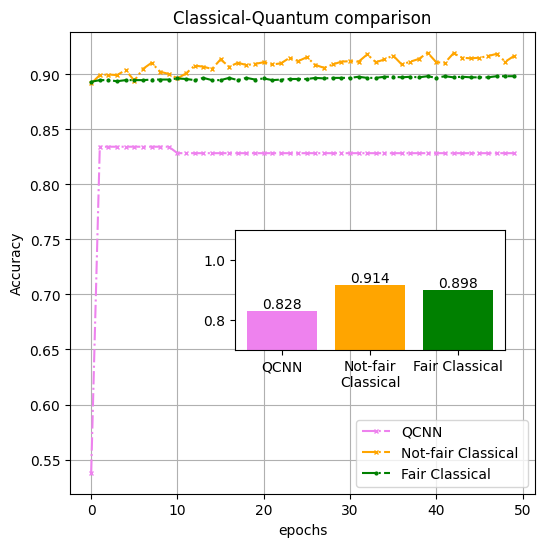

In [211]:
fig, axLL = plt.subplots(1, 1 , figsize=(6, 6))

q_basis = qcnn_basis_results["val_custom_accuracy"]
l5 = lenet5_results["val_accuracy"]
f = fnn_results["val_accuracy"]


axLL.plot(q_basis,"-.", marker= "x", markersize=3, label = "QCNN", color="violet")
axLL.plot(l5,"-.", marker= "x", markersize=3, label = "Not-fair Classical ", color="orange")
axLL.plot(f,"-.", marker= "o", markersize=2, label = "Fair Classical", color="green")



axLL.set_xlabel("epochs")
axLL.set_ylabel("Accuracy")
axLL.legend(loc = 'best')
axLL.set_title("Classical-Quantum comparison")
#axLL.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")
l, b, h, w = .4, .35, .2, .45
ax3 = fig.add_axes([l, b, w, h])
plt.ylim(0.7, 1.1)
x = ["QCNN", "Not-fair\nClassical", "Fair Classical"]
y = [np.mean(q_basis[30:]), np.mean(l5[30:]), np.mean(f[30:])]
plt.bar(x,y, color=("violet", "orange","green" ))
# Adding labels to each bar

for i in range(len(x)):
    plt.text(x[i], y[i], '{:.3f}'.format(y[i]), ha='center', va='bottom')
    
plt.savefig("basis_encoding.jpg")

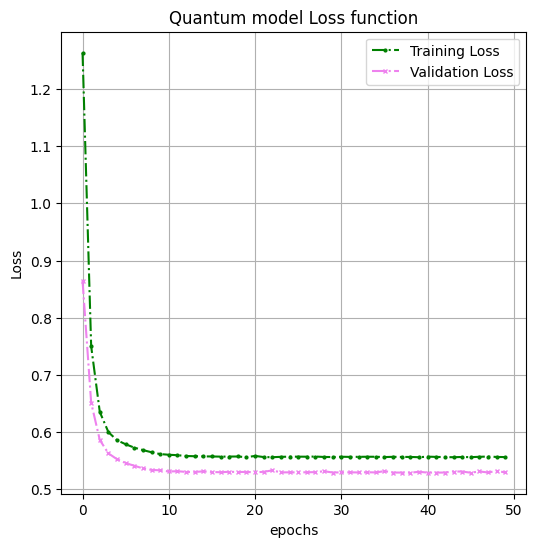

In [213]:
fig, axLL = plt.subplots(1, 1 , figsize=(6, 6))

val_loss = qcnn_basis_results["val_loss"]
tr_loss = qcnn_basis_results["loss"]


axLL.plot(tr_loss,"-.", marker= "o", markersize=2, label = "Training Loss", color="green")
axLL.plot(val_loss,"-.", marker= "x", markersize=3, label = "Validation Loss", color="violet")

axLL.set_xlabel("epochs")
axLL.set_ylabel("Loss")
axLL.legend(loc = 'best')
axLL.set_title("Quantum model Loss function")
#axLL.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")

plt.savefig("basis_encoding_loss.jpg")

### ANGLE ENCODING

In [181]:
### LOAD RESULTS

filename = "results_3by3_angle.json"
with open(filename, "r") as f:
    results = json.load(f)


qcnn_angle_results = results["qcnn_angle"]
lenet5_results = results["lenet5"]
fnn_results = results["fnn"]

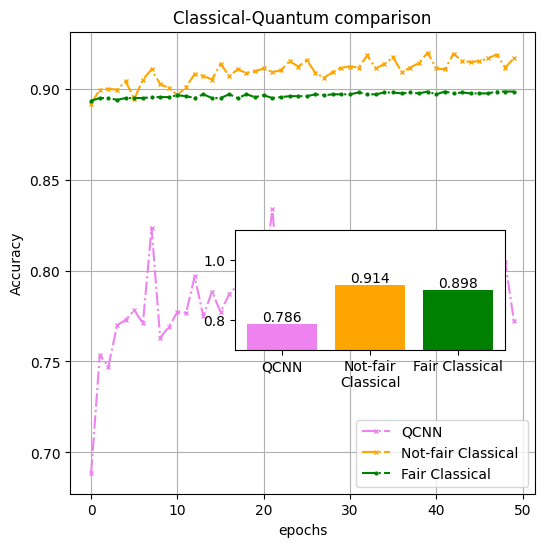

In [212]:
fig, axLL = plt.subplots(1, 1 , figsize=(6, 6))

q_angle = qcnn_angle_results["val_custom_accuracy"]
l5 = lenet5_results["val_accuracy"]
f = fnn_results["val_accuracy"]


axLL.plot(q_angle,"-.", marker= "x", markersize=3, label = "QCNN", color="violet")
axLL.plot(l5,"-.", marker= "x", markersize=3, label = "Not-fair Classical ", color="orange")
axLL.plot(f,"-.", marker= "o", markersize=2, label = "Fair Classical", color="green")



axLL.set_xlabel("epochs")
axLL.set_ylabel("Accuracy")
axLL.legend(loc = 'best')
axLL.set_title("Classical-Quantum comparison")
#axLL.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")
l, b, h, w = .4, .35, .2, .45
ax3 = fig.add_axes([l, b, w, h])
plt.ylim(0.7, 1.1)
x = ["QCNN", "Not-fair\nClassical", "Fair Classical"]
y = [np.mean(q_angle[30:]), np.mean(l5[30:]), np.mean(f[30:])]
plt.bar(x,y, color=("violet", "orange","green" ))
# Adding labels to each bar

for i in range(len(x)):
    plt.text(x[i], y[i], '{:.3f}'.format(y[i]), ha='center', va='bottom')
    
plt.savefig("angle_encoding.jpg")

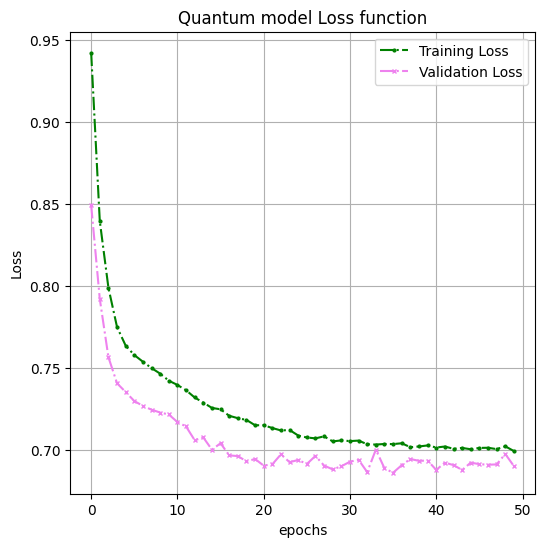

In [193]:
fig, axLL = plt.subplots(1, 1 , figsize=(6, 6))

val_loss = qcnn_angle_results["val_loss"]
tr_loss = qcnn_angle_results["loss"]


axLL.plot(tr_loss,"-.", marker= "o", markersize=2, label = "Training Loss", color="green")
axLL.plot(val_loss,"-.", marker= "x", markersize=3, label = "Validation Loss", color="violet")

axLL.set_xlabel("epochs")
axLL.set_ylabel("Loss")
axLL.legend(loc = 'best')
axLL.set_title("Quantum model Loss function")
#axLL.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")

plt.savefig("angle_encoding_loss.jpg")

## PARAMETRIZED CIRCUITS

In [32]:
def circuit_2(symbols, qubits):
    circuit = cirq.Circuit()
    
    circuit += cirq.rx(symbols[0]).on(qubits[0])
    circuit += cirq.rx(symbols[1]).on(qubits[1])
    circuit += cirq.rx(symbols[2]).on(qubits[2])
    circuit += cirq.rx(symbols[3]).on(qubits[3])

    circuit += cirq.rz(symbols[4]).on(qubits[0])
    circuit += cirq.rz(symbols[5]).on(qubits[1])
    circuit += cirq.rz(symbols[6]).on(qubits[2])
    circuit += cirq.rz(symbols[7]).on(qubits[3])
        
    circuit += cirq.CNOT(qubits[1], qubits[0])
    circuit += cirq.CNOT(qubits[2], qubits[1])
    circuit += cirq.CNOT(qubits[3], qubits[2])
    
    return circuit

def circuit_11(symbols, qubits):
    circuit = cirq.Circuit()
    
    circuit += cirq.ry(symbols[0]).on(qubits[0])
    circuit += cirq.ry(symbols[1]).on(qubits[1])
    circuit += cirq.ry(symbols[2]).on(qubits[2])
    circuit += cirq.ry(symbols[3]).on(qubits[3])

    circuit += cirq.rz(symbols[4]).on(qubits[0])
    circuit += cirq.rz(symbols[5]).on(qubits[1])
    circuit += cirq.rz(symbols[6]).on(qubits[2])
    circuit += cirq.rz(symbols[7]).on(qubits[3])

    circuit += cirq.CNOT(qubits[1], qubits[0])
    circuit += cirq.CNOT(qubits[3], qubits[2])
    
    circuit += cirq.ry(symbols[8]).on(qubits[1])
    circuit += cirq.ry(symbols[9]).on(qubits[2])
    
    circuit += cirq.rz(symbols[10]).on(qubits[1])
    circuit += cirq.rz(symbols[11]).on(qubits[2])
    
    circuit += cirq.CNOT(qubits[2], qubits[1])
    
    return circuit


def circuit_12(symbols, qubits):
    circuit = cirq.Circuit()
    
    circuit += cirq.ry(symbols[0]).on(qubits[0])
    circuit += cirq.ry(symbols[1]).on(qubits[1])
    circuit += cirq.ry(symbols[2]).on(qubits[2])
    circuit += cirq.ry(symbols[3]).on(qubits[3])

    circuit += cirq.rz(symbols[4]).on(qubits[0])
    circuit += cirq.rz(symbols[5]).on(qubits[1])
    circuit += cirq.rz(symbols[6]).on(qubits[2])
    circuit += cirq.rz(symbols[7]).on(qubits[3])


    circuit += cirq.CZ(qubits[0], qubits[1])
    circuit += cirq.CZ(qubits[2], qubits[3])
    
    circuit += cirq.ry(symbols[8]).on(qubits[1])
    circuit += cirq.ry(symbols[9]).on(qubits[2])

    circuit += cirq.rz(symbols[10]).on(qubits[1])
    circuit += cirq.rz(symbols[11]).on(qubits[2])

    circuit += cirq.CZ(qubits[1], qubits[2])

    return circuit
    
    

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


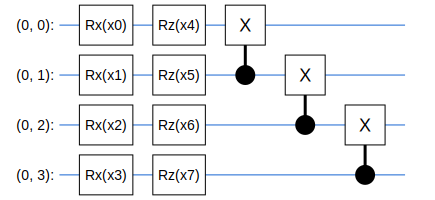

In [33]:
test_bits = cirq.GridQubit.rect(1, 4)


SVGCircuit(
    circuit_2(sympy.symbols('x0:10'), test_bits))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


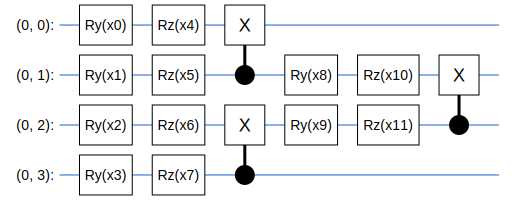

In [34]:
SVGCircuit(circuit_11(sympy.symbols('x0:12'), test_bits))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


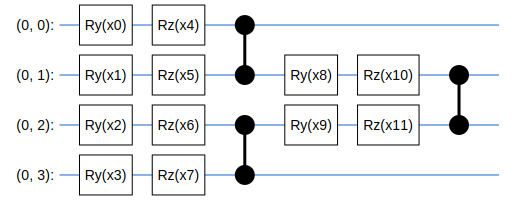

In [35]:
SVGCircuit(circuit_12(sympy.symbols('x0:12'), test_bits))